# Proyecto Final

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

# Introducción: 

Antes que nada en los siguientes primeros pasos procederé a hacer el análisis de los datos proporcionados para el proyecto y una vez que haya visto la información general procederé a hacer la limpieza de datos correspondiente para tener una mejor estructura y los datos correctamente organizados para la base del proyecto.

# Primera Parte

# Análisis Exploratorio de Datos 

# Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.utils import shuffle
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# Dataframes y análisis de datos

In [2]:
contract = pd.read_csv(r'/datasets/final_provider/contract.csv')
personal = pd.read_csv(r'/datasets/final_provider/personal.csv')
internet = pd.read_csv(r'/datasets/final_provider/internet.csv')
phone = pd.read_csv(r'/datasets/final_provider/phone.csv')

In [3]:
contract.info()
personal.info()
internet.info()
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   D

In [4]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [5]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [6]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,9327-QSDED,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [7]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,9327-QSDED,No
freq,1,3390


# Limpieza de datos

A continuación procedere a hacer la limpieza de datos pero antes de eso haré una mezcla entre los dataframes ya que la informacíon viene compartida entre estos y considero es mejor y más práctico mezclarlos para trabajarlos.

In [8]:
df_merge = contract.merge(personal, on='customerID', how='left').merge(
    internet, on='customerID', how='left').merge(phone, on='customerID', how='left')

print(df_merge.columns)

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')


Ahora modoficaré los nombres de las columnas ya que vienen en una mala estructura que complica el trabajo y puede ocasionar retrasos y errores, por eso cambiaré los nombres para manejarlos de manera mas eficaz y reducir el riesgo de error.

In [9]:
new_columns = {'customerID': 'customer_id', 'BeginDate': 'begin_date', 'EndDate': 'end_date', 'Type': 'type', 'PaperlessBilling': 'paperless_billing',
               'PaymentMethod': 'payment_method', 'MonthlyCharges': 'monthly_charges', 'TotalCharges': 'total_charges',
               'SeniorCitizen': 'senior_citizen', 'Partner': 'partner', 'Dependents': 'dependents', 'InternetService': 'internet_service',
               'OnlineSecurity': 'online_security', 'OnlineBackup': 'online_backup', 'DeviceProtection': 'device_protection', 'TechSupport': 'tech_support',
               'StreamingTV': 'streaming_tv', 'StreamingMovies': 'streaming_movies', 'MultipleLines': 'multiple_lines'}

df_merge.rename(columns=new_columns, inplace=True)
print(df_merge.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')


Anexo de columna ¨desertion¨: Antes de continuar con la limpieza de los datos, anexaré la columna desertion con valores booleanos para clientes que no han abandonado el servicio con 0 y con 1 para los que abandonaron la compañía, todo esto para fines de la exploración, entrenamiento y procesado de los futuros modelos.

In [10]:
df_merge['desertion'] = df_merge['end_date'].apply(
    lambda x:  0 if x == 'No' else 1)

In [11]:
print(df_merge.info())
print(df_merge['desertion'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

Verificación de valores duplicados:

In [12]:
print('valores duplicados:', df_merge['customer_id'].duplicated().sum())

valores duplicados: 0


Valores ausentes:

In [13]:
total_rows = df_merge.shape[0]
null_count = df_merge.isnull().sum()
null_values = (null_count/total_rows) * 100

print("valores ausentes en cada columna:")

print(null_values)

valores ausentes en cada columna:
customer_id           0.000000
begin_date            0.000000
end_date              0.000000
type                  0.000000
paperless_billing     0.000000
payment_method        0.000000
monthly_charges       0.000000
total_charges         0.000000
gender                0.000000
senior_citizen        0.000000
partner               0.000000
dependents            0.000000
internet_service     21.666903
online_security      21.666903
online_backup        21.666903
device_protection    21.666903
tech_support         21.666903
streaming_tv         21.666903
streaming_movies     21.666903
multiple_lines        9.683374
desertion             0.000000
dtype: float64


Manejo de datos vacíos: debido a que no hay duplicados, manejaré y subsanaré los datos vacíos con la técnica simpleimputer de sklearn.

In [14]:
categorical_columns = ['internet_service', 'online_security',
                       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
                       'streaming_movies', 'multiple_lines']

imputer = SimpleImputer(strategy='most_frequent')

for i in categorical_columns:
    df_merge[i] = imputer.fit_transform(df_merge[[i]]).ravel()

print(df_merge.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

A continuación cambiaré la columna total_charges que es de tipo objeto a numérico:

In [15]:
df_merge['total_charges'] = df_merge['total_charges'].replace(
    ' ', np.nan)

df_merge['total_charges'] = pd.to_numeric(df_merge['total_charges'])

imputer = IterativeImputer(max_iter=10, random_state=42)
df_merge[['total_charges']] = imputer.fit_transform(
    df_merge[['total_charges']])


print(df_merge.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   float64
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   7043 non-null   object 
 13  online_security    7043 non-null   object 
 14  online_backup      7043 non-null   object 
 15  device_protection  7043 non-null   object 
 16  tech_support       7043 

Ahora eliminaré las columnas begin_date y end_date ya que al crear la columna desert considero remplazé lo que aportaban estas dos para saber si los clientes estaban o no en el servicio, por eso considero ya no las ocuparé para continuar el trabajo.

In [16]:
print(df_merge.columns)

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines', 'desertion'],
      dtype='object')


In [17]:
df_merge.drop(columns=['end_date', 'begin_date'], inplace=True)

In [18]:
print(df_merge.columns)

Index(['customer_id', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges', 'gender', 'senior_citizen',
       'partner', 'dependents', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'multiple_lines', 'desertion'],
      dtype='object')


# Gráficos

A continuación crearé una serie de gráficos que pueden ayudar a visualisar y analizar la distribución de algunos datos e identificar patrones.

# Variables Numéricas

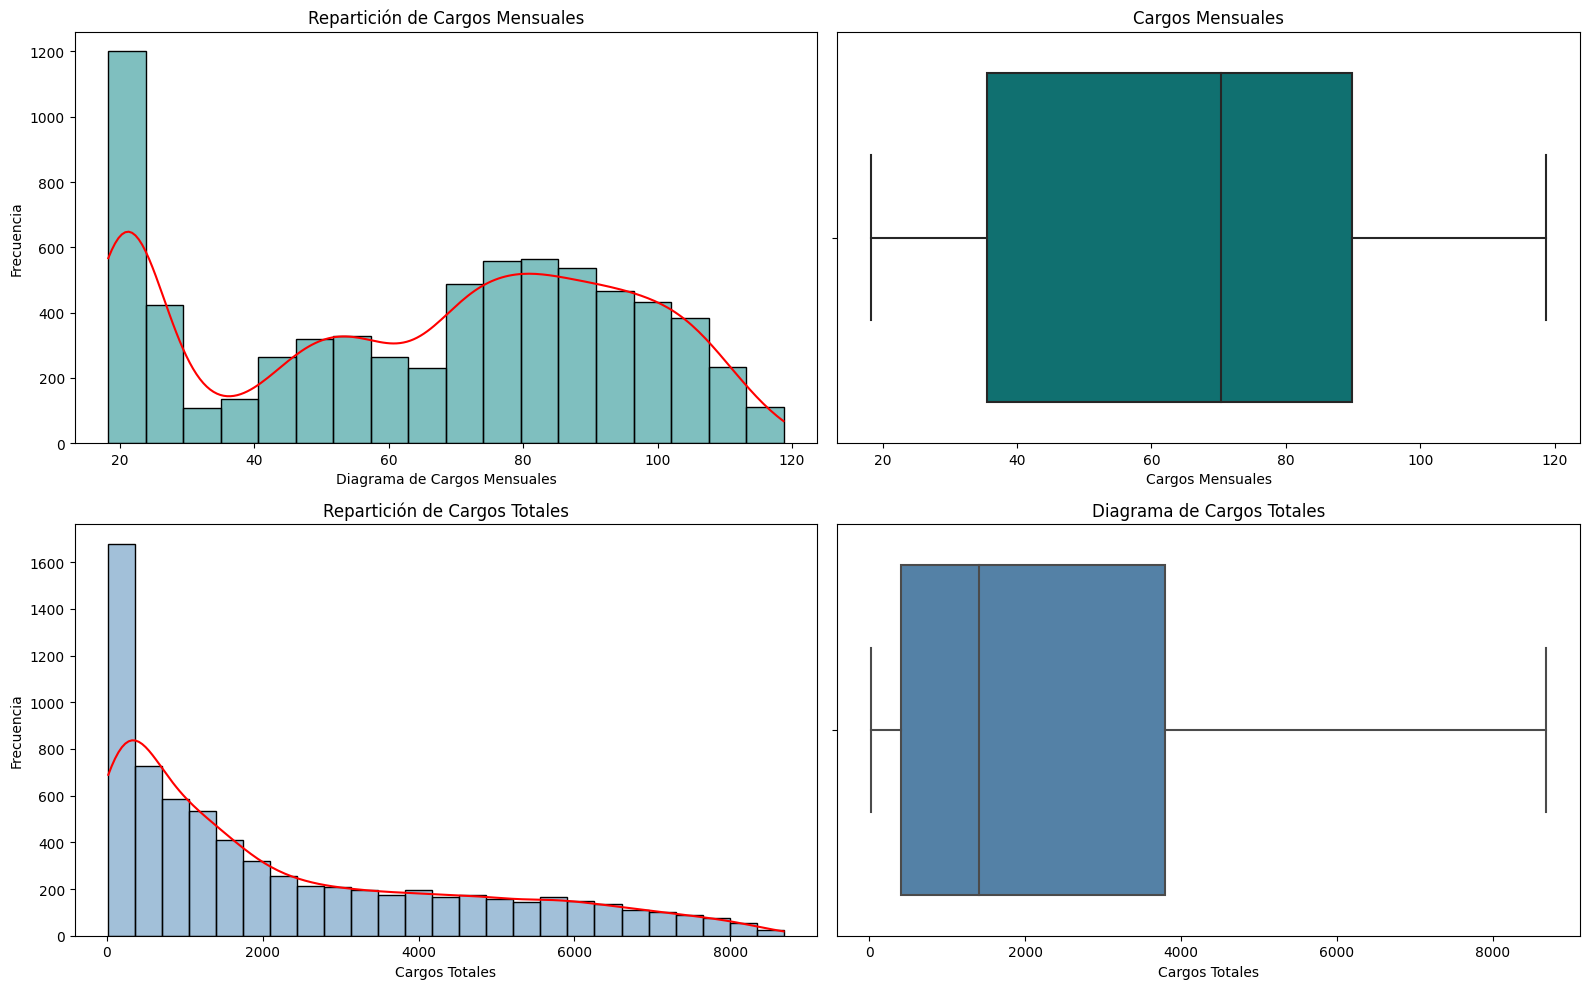

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

ax = axs[0, 0]
sns.histplot(df_merge['monthly_charges'], kde=True, ax=ax, color='teal')
ax.lines[0].set_color('red')
ax.set_title('Repartición de Cargos Mensuales')
ax.set_xlabel('Diagrama de Cargos Mensuales')
ax.set_ylabel('Frecuencia')

ax = axs[0, 1]
sns.boxplot(x=df_merge['monthly_charges'], ax=ax, color='teal')
ax.set_title('Cargos Mensuales')
ax.set_xlabel('Cargos Mensuales')

ax = axs[1, 0]
sns.histplot(df_merge['total_charges'], kde=True, ax=ax, color='steelblue')
ax.lines[0].set_color('red')
ax.set_title('Repartición de Cargos Totales')
ax.set_xlabel('Cargos Totales')
ax.set_ylabel('Frecuencia')

ax = axs[1, 1]
sns.boxplot(x=df_merge['total_charges'], ax=ax, color='steelblue')
ax.set_title('Diagrama de Cargos Totales')
ax.set_xlabel('Cargos Totales')

fig.tight_layout()
plt.show()

Anteriormente realizé unas gráficas para mostrar la distribución de las variables numéricas en realación con los cargos mensuales y los cargos totales, de las cuales se puede interpretar que la mayor parte de los clientes optan por planes económicos mientras que en los diagramas de caja, se puede observar que al parecer no hay datos extremos significativos por lo cual las tarifas de servicio y los cargos totales parece que están distribuidos de manera razonable sin valores atípicos.

# Columna desertion

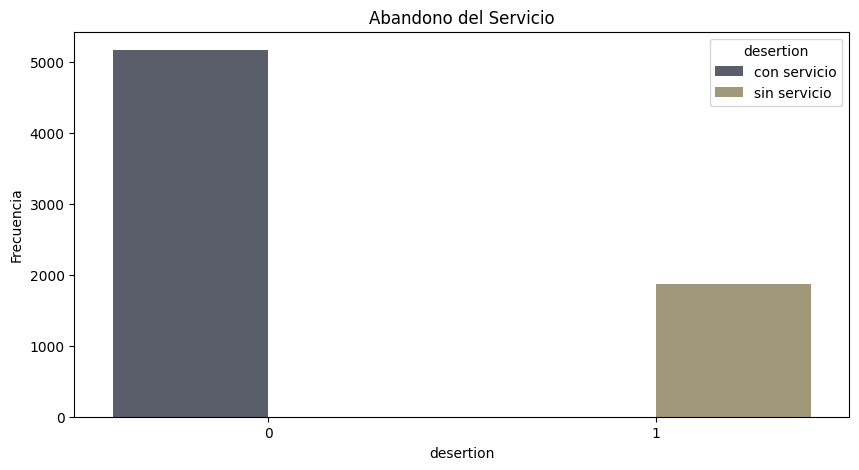

In [20]:
palet = sns.color_palette('cividis', 2)

plt.figure(figsize=(10, 5))
sns.countplot(x='desertion', data=df_merge, hue='desertion', palette=palet)
plt.title('Abandono del Servicio')
plt.xlabel('desertion')
plt.ylabel('Frecuencia')
plt.legend(['con servicio', 'sin servicio'], title='desertion', loc='upper right')
plt.show()

En el ejercicio anterior realicé un gráfico para analizar la columna desertion en cuanto al índice de abandono del servicio, es decir, analizar la cantidad de usuarios que han abandonado el servicio y los que aún continúan con el. Se puede observar que una gran parte de los clientes han abandonado el servicio lo cual se tiene que manejar con cuidado al desarrollar los modelos ya que el alto índice de abandono podría ocasionar problemas por lo tanto se tendría que tomar en cuenta el balance de los datos previamente para evitar la obtención de resultados erroneos y poco precisos.

# Relación entre las variables numéricas y la columna desertion

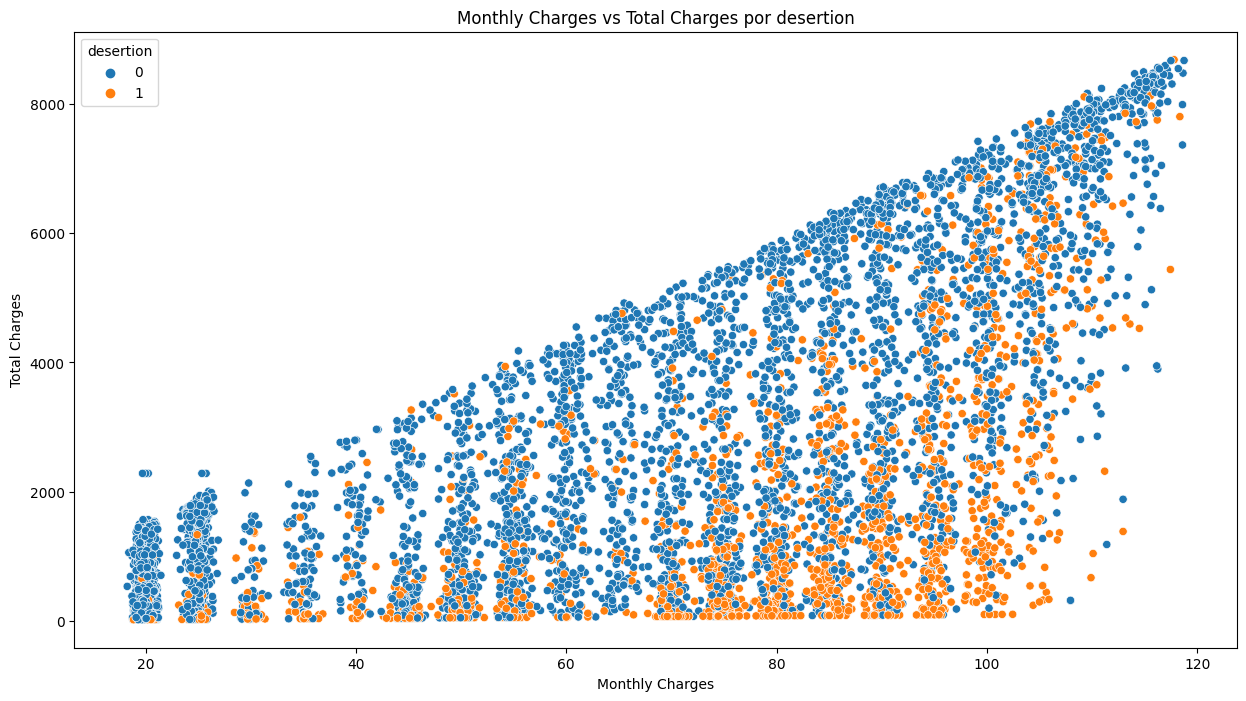

In [21]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x=df_merge['monthly_charges'],
                y=df_merge['total_charges'], hue=df_merge['desertion'])
plt.title('Monthly Charges vs Total Charges por desertion')
plt.xlabel('Monthly Charges')
plt.ylabel('Total Charges')
plt.legend(title='desertion')
plt.show()

En el ejercicio anterior creé un gráfico que representara la relación entre las variables numéricas y la tasa de abandono representada por la columna desertion y se puede observar que la mayoría de clientes que abandonaron tenían varios servicios contratados y usualmente tenían contratos a mediano plazo lo cual es un dato importante para que, como se menciona, el departamento de marketing pueda crear estrategias de retención para este tipo de clientes.

# Segunda Parte

# Creación de dummies

En la segunda parte del proyecto final comenzaré con la creación de dummies para las características categóricas, primero haré la división de columnas numéricas y categóricas selecionnado las columnas categóricas para crear variables dummy y despúes combinaré estas con las columnas numéricas en un nuevo dataframe.

In [22]:
cat_columns = df_merge.drop(
    columns=['customer_id', 'monthly_charges', 'total_charges', 'desertion']).columns

cat_columns_df = pd.get_dummies(
    df_merge[cat_columns], drop_first=True)

numerical_columns = df_merge[['monthly_charges', 'total_charges', 'desertion']]

df_final1 = pd.concat([cat_columns_df, numerical_columns], axis=1)

print(df_final1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   senior_citizen                          7043 non-null   int64  
 1   type_One year                           7043 non-null   uint8  
 2   type_Two year                           7043 non-null   uint8  
 3   paperless_billing_Yes                   7043 non-null   uint8  
 4   payment_method_Credit card (automatic)  7043 non-null   uint8  
 5   payment_method_Electronic check         7043 non-null   uint8  
 6   payment_method_Mailed check             7043 non-null   uint8  
 7   gender_Male                             7043 non-null   uint8  
 8   partner_Yes                             7043 non-null   uint8  
 9   dependents_Yes                          7043 non-null   uint8  
 10  internet_service_Fiber optic            7043 non-null   uint

# Manejo del desequilibrio de clases

En el siguiente paso procederé a manejar el desequilibrio de clases ya que como se vió en la primera parte era una diferencia importante entre la parte mayoritaria y la minoritaria, entonces procederé primero a sobremuestrear la clase minoritaria para despues mezclar esta con la clase mayoritaria y lo guardaré en otro dataframe.

In [23]:
df_major = df_final1[df_final1['desertion'] == 0]
df_minor = df_final1[df_final1['desertion'] == 1]

df_minor_oversampled = df_minor.sample(len(df_major), replace=True, random_state=24680)

df_resampled = pd.concat([df_major, df_minor_oversampled])

df_final2 = shuffle(df_resampled, random_state=24680)

print(df_final2['desertion'].value_counts())

0    5174
1    5174
Name: desertion, dtype: int64


# Selección de características

En este apartado procederé a realizar la selección de características aplicando dos métodos: 

En el primero  aplicaré un método de filtrado en donde trataré de detectar todas las características que tengan una alta correlación entre sí para así proceder a eliminar una de ellas y así poder evitar la multicolinealidad.   
 
En el segundo aplicaré un método de wrapping con randomforest para seleccionar 15 de las características más importantes del dataframe.

Al realizar estos pasos de selección de características se crearán dos dataframe con los cuales trabajaré en los siguientes pasos para la creación de los modelos.


# Filtrado

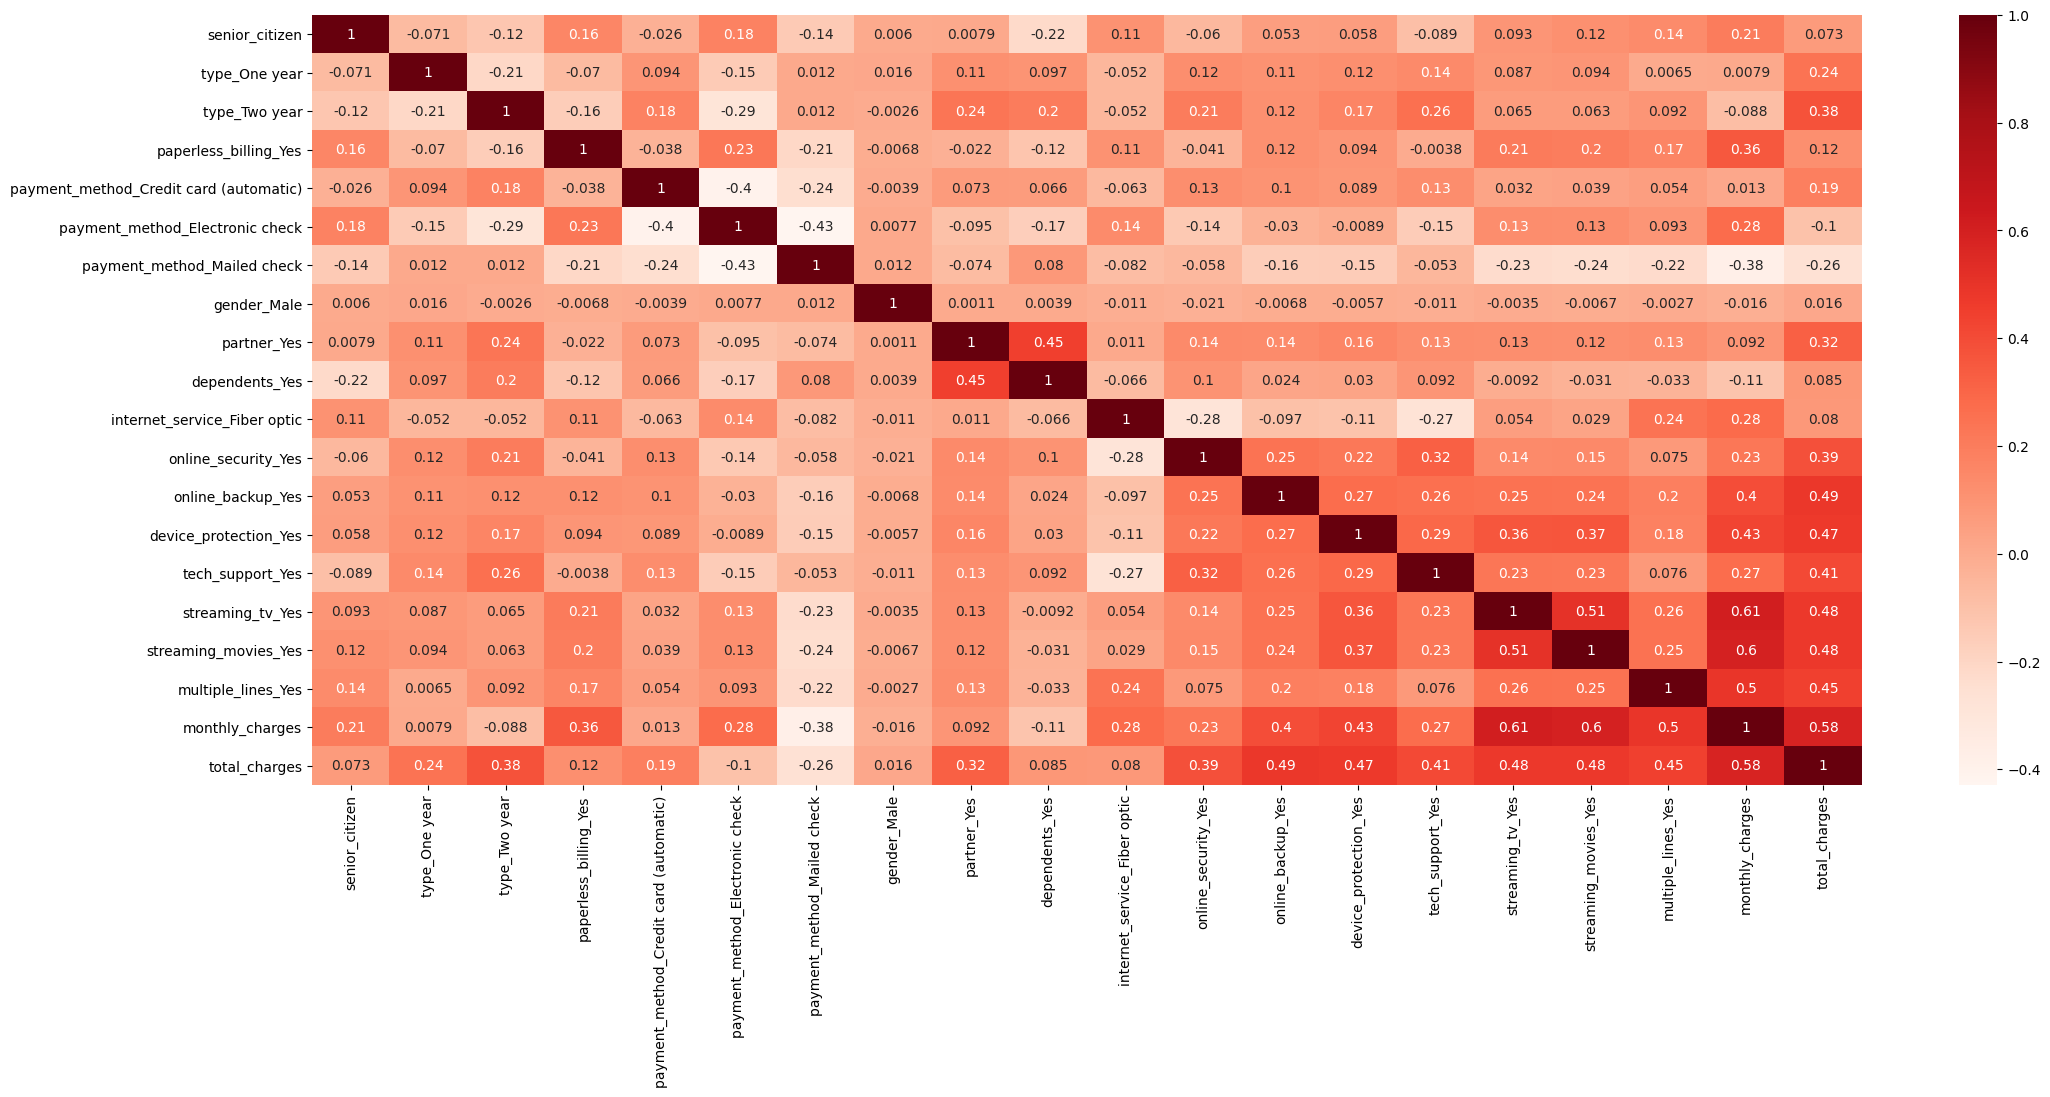

Características por SelectKBest:
Index(['senior_citizen', 'type_One year', 'type_Two year',
       'paperless_billing_Yes', 'payment_method_Credit card (automatic)',
       'payment_method_Electronic check', 'payment_method_Mailed check',
       'partner_Yes', 'dependents_Yes', 'online_security_Yes',
       'tech_support_Yes', 'monthly_charges', 'total_charges'],
      dtype='object')


In [24]:
features = df_final2.drop(columns=['desertion'])
target = df_final2['desertion']

correlation_matrix = features.corr()
plt.figure(figsize=(25, 10))
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

threshold = 0.8
high_corr_var = np.where(np.abs(correlation_matrix) > threshold)
high_corr_var = [(correlation_matrix.columns[x], correlation_matrix.columns[y])
                 for x, y in zip(*high_corr_var) if x != y and x < y]

for x, y in high_corr_var:
    features = features.drop(columns=[y])

select_k_best = SelectKBest(chi2, k=13)
select_k_best.fit(features, target)

kbest_features = features.columns[select_k_best.get_support()]

print("Características por SelectKBest:")
print(kbest_features)

# Wrapping RFE con RandomForestClassifier:

In [25]:
model = RandomForestClassifier(random_state=24680)
rfe = RFE(estimator=model, n_features_to_select=13)
features_rfe = rfe.fit_transform(features, target)

rfe_features = features.columns[rfe.support_]

print("Características seleccionadas por RFE:")
print(rfe_features)

Características seleccionadas por RFE:
Index(['type_One year', 'type_Two year', 'paperless_billing_Yes',
       'payment_method_Electronic check', 'gender_Male', 'partner_Yes',
       'internet_service_Fiber optic', 'online_security_Yes',
       'online_backup_Yes', 'device_protection_Yes', 'tech_support_Yes',
       'monthly_charges', 'total_charges'],
      dtype='object')


Intersección y unión de características de los dos métodos:

In [26]:
inter_features = list(set(kbest_features) & set(rfe_features))
print("Intersección de métodos:")
print(inter_features)

union_features = list(set(kbest_features) | set(rfe_features))
print("Unión de métodos:")
print(union_features)

Intersección de métodos:
['monthly_charges', 'payment_method_Electronic check', 'type_Two year', 'paperless_billing_Yes', 'tech_support_Yes', 'type_One year', 'online_security_Yes', 'total_charges', 'partner_Yes']
Unión de métodos:
['monthly_charges', 'payment_method_Electronic check', 'type_Two year', 'gender_Male', 'device_protection_Yes', 'online_backup_Yes', 'type_One year', 'payment_method_Mailed check', 'online_security_Yes', 'total_charges', 'paperless_billing_Yes', 'dependents_Yes', 'tech_support_Yes', 'payment_method_Credit card (automatic)', 'senior_citizen', 'internet_service_Fiber optic', 'partner_Yes']


Creación de DataFrames con características seleccionadas

In [27]:
df_inter = df_final2[inter_features + ['desertion']]
df_union = df_final2[union_features + ['desertion']]

print("Información con intersección de características:")
print(df_inter.info())

Información con intersección de características:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10348 entries, 433 to 3976
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   monthly_charges                  10348 non-null  float64
 1   payment_method_Electronic check  10348 non-null  uint8  
 2   type_Two year                    10348 non-null  uint8  
 3   paperless_billing_Yes            10348 non-null  uint8  
 4   tech_support_Yes                 10348 non-null  uint8  
 5   type_One year                    10348 non-null  uint8  
 6   online_security_Yes              10348 non-null  uint8  
 7   total_charges                    10348 non-null  float64
 8   partner_Yes                      10348 non-null  uint8  
 9   desertion                        10348 non-null  int64  
dtypes: float64(2), int64(1), uint8(7)
memory usage: 394.1 KB
None


In [28]:
print("Información con unión de características:")
print(df_union.info())

Información con unión de características:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10348 entries, 433 to 3976
Data columns (total 18 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   monthly_charges                         10348 non-null  float64
 1   payment_method_Electronic check         10348 non-null  uint8  
 2   type_Two year                           10348 non-null  uint8  
 3   gender_Male                             10348 non-null  uint8  
 4   device_protection_Yes                   10348 non-null  uint8  
 5   online_backup_Yes                       10348 non-null  uint8  
 6   type_One year                           10348 non-null  uint8  
 7   payment_method_Mailed check             10348 non-null  uint8  
 8   online_security_Yes                     10348 non-null  uint8  
 9   total_charges                           10348 non-null  float64
 10  paperless_billi

división de dataframes en conjuntos de entrenamiento y prueba:

In [29]:
def div_test(df):
    x = df.drop(columns=['desertion'])
    y = df['desertion']
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.30, random_state=12345)

    return x_train, x_test, y_train, y_test

Código para el entrenamiento y evaluación de modelos:

In [30]:
def evaluate_model(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)

    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)

    y_pred_proba_train = model.predict_proba(x_train)[:, 1]
    y_pred_proba_test = model.predict_proba(x_test)[:, 1]


    auc_roc_train = roc_auc_score(y_train, y_pred_proba_train)
    auc_roc_test = roc_auc_score(y_test, y_pred_proba_test)
    print(f"AUC ROC de entrenamiento: {auc_roc_train:.4f}")
    print(f"AUC ROC de prueba: {auc_roc_test:.4f}")


    print("Confusion Matrix (prueba):")
    print(confusion_matrix(y_test, y_pred_test))


    accuracy = accuracy_score(y_test, y_pred_test)
    print(f"Accuracy: {accuracy:.4f}")


    precision = precision_score(y_test, y_pred_test)
    print(f"Precision: {precision:.4f}")

 
    f1 = f1_score(y_test, y_pred_test)
    print(f"F1-score: {f1:.4f}")
    
        
    fpr_train, tpr_train, _train = roc_curve(y_train, y_pred_proba_train)
    roc_auc_train = auc(fpr_train, tpr_train)


    fpr_test, tpr_test, _test = roc_curve(y_test, y_pred_proba_test)
    roc_auc_test = auc(fpr_test, tpr_test)

 
    plt.figure()
    plt.plot(fpr_train, tpr_train, color='blue', lw=2,
             label=f'ROC curve (entrenamiento) (area = {roc_auc_train:.4f})')
    plt.plot(fpr_test, tpr_test, color='darkorange', lw=2,
             label=f'ROC curve (prueba) (area = {roc_auc_test:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()

    return

Código de prevención y comprobación para visualizar si hay sobreajuste en los modelos entrenados con validación cruzada:

In [31]:
def evaluate_model_with_cv(model, x_test, y_test, cv=10):
    
    scores = cross_val_score(model, x_test, y_test, cv=cv, scoring='roc_auc')
    print(f"AUC ROC promedio en validación cruzada: {scores.mean():.4f} +/- {scores.std():.4f}")

    return

Asignación de sets de entrenamiento y prueba para la unión e intersección de características:

In [32]:
x_train, x_test, y_train, y_test = div_test(df_union)

x_trainI, x_testI, y_trainI, y_testI = div_test(df_inter)

# Creación de modelos

A continuación realizaré pruebas con diferentes modelos para ver cuál es el que nos arroja mejores resultados para nuestro propósito y tomando en cuenta las dos divisiones que creé anteriormente, es decir, con la unión de las características y con la intersección de las características.

# DummyClassifier (base)

AUC ROC de entrenamiento: 0.5000
AUC ROC de prueba: 0.5000
Confusion Matrix (prueba):
[[   0 1528]
 [   0 1577]]
Accuracy: 0.5079
Precision: 0.5079
F1-score: 0.6736


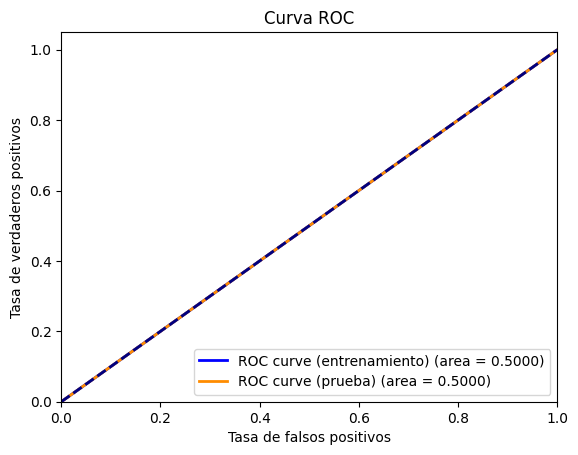

In [33]:
model_DC = DummyClassifier(strategy='constant', constant=1)
evaluate_model(model_DC, x_train, x_test, y_train, y_test)

# Modelo de Regresión Logística

## Con unión de características:

In [34]:
model_regresion = LogisticRegression(max_iter=1000, random_state=1234)

AUC ROC de entrenamiento: 0.8388
AUC ROC de prueba: 0.8305
Confusion Matrix (prueba):
[[1094  434]
 [ 350 1227]]
Accuracy: 0.7475
Precision: 0.7387
F1-score: 0.7579


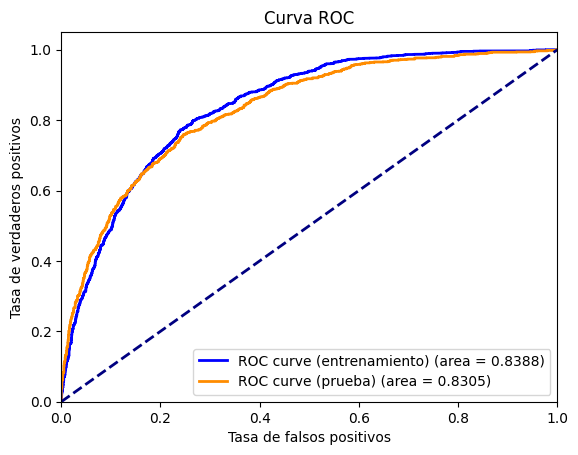

AUC ROC promedio en validación cruzada: 0.8272 +/- 0.0163


In [35]:
evaluate_model(model_regresion, x_train, x_test, y_train, y_test)

evaluate_model_with_cv(model_regresion, x_test, y_test)

## Con intersección de características:

AUC ROC de entrenamiento: 0.8318
AUC ROC de prueba: 0.8242
Confusion Matrix (prueba):
[[1128  400]
 [ 379 1198]]
Accuracy: 0.7491
Precision: 0.7497
F1-score: 0.7546


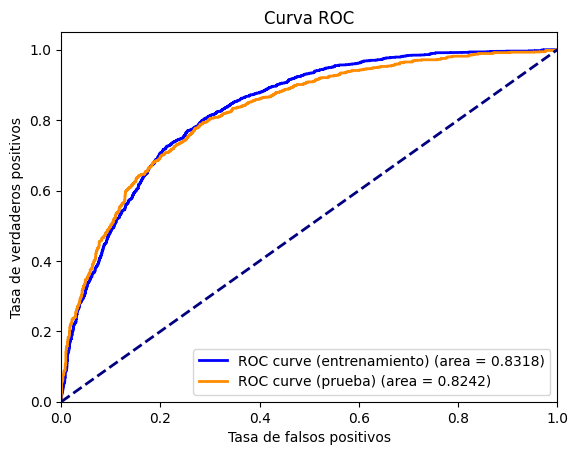

AUC ROC promedio en validación cruzada: 0.8270 +/- 0.0168


In [36]:
evaluate_model(model_regresion, x_trainI, x_testI, y_trainI, y_testI)

evaluate_model_with_cv(model_regresion, x_testI, y_testI)

# Modelo de Random Forest

##  Con unión de características:

AUC ROC de entrenamiento: 0.9955
AUC ROC de prueba: 0.9348
Confusion Matrix (prueba):
[[1236  292]
 [ 147 1430]]
Accuracy: 0.8586
Precision: 0.8304
F1-score: 0.8669


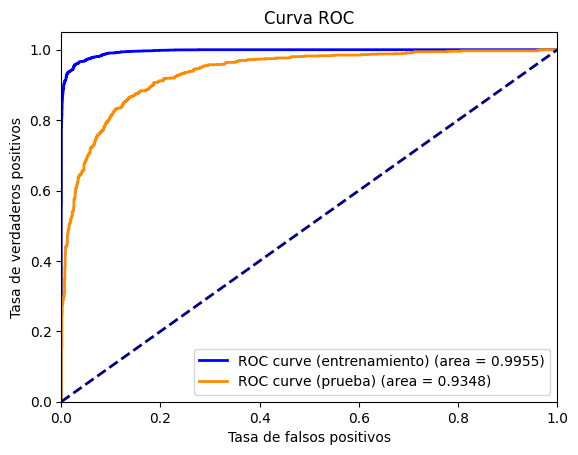

AUC ROC promedio en validación cruzada: 0.8873 +/- 0.0190


In [37]:
model_RF = RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_split=3,  min_samples_leaf=2, random_state=1234)

evaluate_model(model_RF, x_train, x_test, y_train, y_test)

evaluate_model_with_cv(model_RF, x_test, y_test)

## Con intersección de características:

AUC ROC de entrenamiento: 0.9957
AUC ROC de prueba: 0.9261
Confusion Matrix (prueba):
[[1231  297]
 [ 160 1417]]
Accuracy: 0.8528
Precision: 0.8267
F1-score: 0.8611


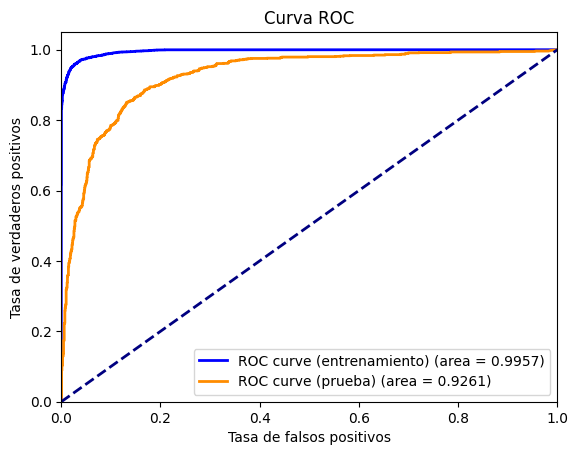

AUC ROC promedio en validación cruzada: 0.8778 +/- 0.0158


In [38]:
evaluate_model(model_RF, x_trainI, x_testI, y_trainI, y_testI)
evaluate_model_with_cv(model_RF, x_testI, y_testI)

# Modelo de Gradient Boosting

## Con unión de características:

AUC ROC de entrenamiento: 0.8993
AUC ROC de prueba: 0.8671
Confusion Matrix (prueba):
[[1151  377]
 [ 261 1316]]
Accuracy: 0.7945
Precision: 0.7773
F1-score: 0.8049


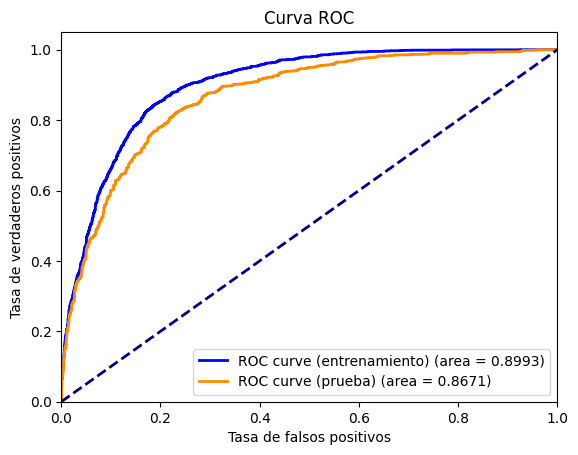

AUC ROC promedio en validación cruzada: 0.8519 +/- 0.0204


In [39]:
model_Gradient = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5, max_depth=2,
                                      min_samples_split=3, min_samples_leaf=2, subsample=1, random_state=1234)

evaluate_model(model_Gradient, x_train, x_test, y_train, y_test)
evaluate_model_with_cv(model_Gradient, x_test, y_test)

## Con intersección de características:

AUC ROC de entrenamiento: 0.8982
AUC ROC de prueba: 0.8651
Confusion Matrix (prueba):
[[1159  369]
 [ 287 1290]]
Accuracy: 0.7887
Precision: 0.7776
F1-score: 0.7973


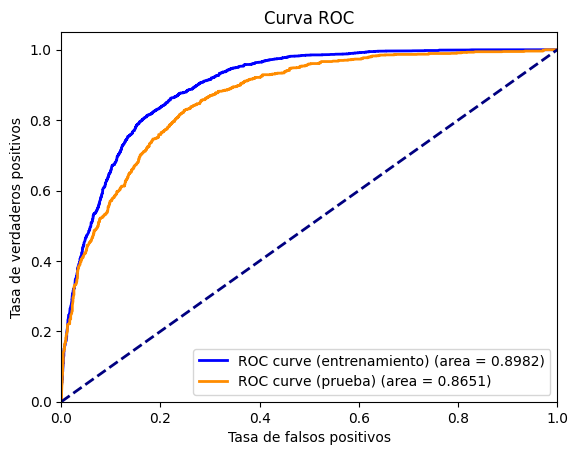

AUC ROC promedio en validación cruzada: 0.8518 +/- 0.0181


In [40]:
evaluate_model(model_Gradient, x_trainI, x_testI, y_trainI, y_testI)

evaluate_model_with_cv(model_Gradient, x_testI, y_testI)

# Modelo KNN

## Con unión de características:

AUC ROC de entrenamiento: 0.9273
AUC ROC de prueba: 0.8373
Confusion Matrix (prueba):
[[1059  469]
 [ 267 1310]]
Accuracy: 0.7630
Precision: 0.7364
F1-score: 0.7807


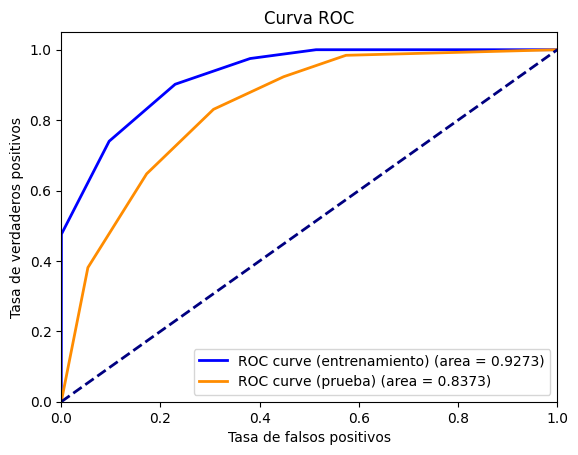

AUC ROC promedio en validación cruzada: 0.7877 +/- 0.0155


In [41]:
model_KNN = KNeighborsClassifier()

evaluate_model(model_KNN, x_train, x_test, y_train, y_test)
evaluate_model_with_cv(model_KNN, x_test, y_test)

## Con intersección de características:

AUC ROC de entrenamiento: 0.9282
AUC ROC de prueba: 0.8407
Confusion Matrix (prueba):
[[1064  464]
 [ 269 1308]]
Accuracy: 0.7639
Precision: 0.7381
F1-score: 0.7811


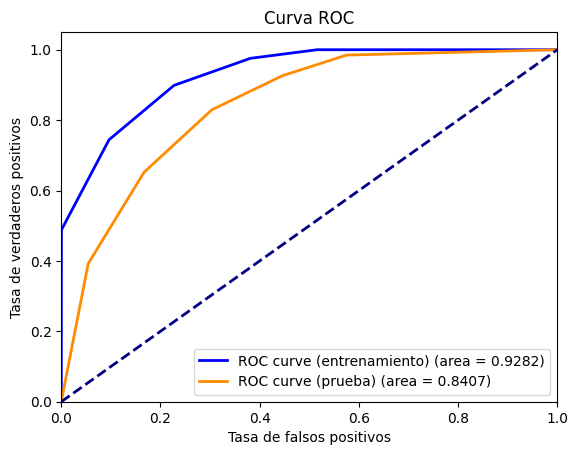

AUC ROC promedio en validación cruzada: 0.7859 +/- 0.0129


In [42]:
evaluate_model(model_KNN, x_trainI, x_testI, y_trainI, y_testI)

evaluate_model_with_cv(model_KNN, x_testI, y_testI)

# Modelo de CatBoost Classifier

## Con unión de características:

AUC ROC de entrenamiento: 0.9760
AUC ROC de prueba: 0.9152
Confusion Matrix (prueba):
[[1211  317]
 [ 160 1417]]
Accuracy: 0.8464
Precision: 0.8172
F1-score: 0.8559


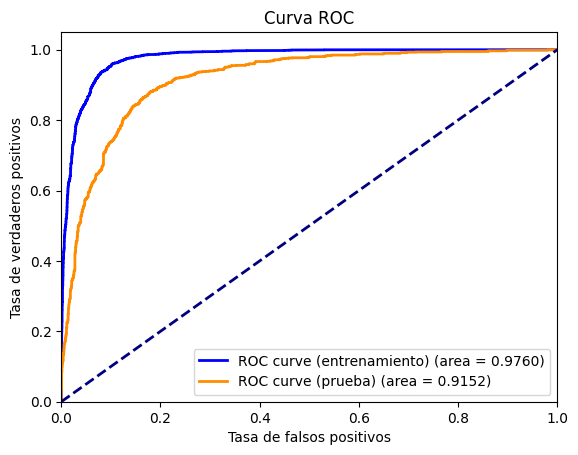

AUC ROC promedio en validación cruzada: 0.8805 +/- 0.0195


In [43]:
model_CBC = CatBoostClassifier(
    iterations=1300, learning_rate=0.04, depth=6, l2_leaf_reg=4, random_state=1234, verbose=0)

evaluate_model(model_CBC, x_train, x_test, y_train, y_test)
evaluate_model_with_cv(model_CBC, x_test, y_test)

## Con intersección de características:

AUC ROC de entrenamiento: 0.9634
AUC ROC de prueba: 0.9014
Confusion Matrix (prueba):
[[1193  335]
 [ 182 1395]]
Accuracy: 0.8335
Precision: 0.8064
F1-score: 0.8437


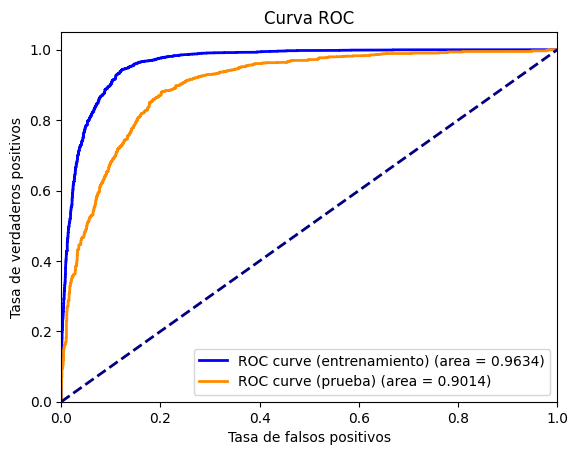

AUC ROC promedio en validación cruzada: 0.8725 +/- 0.0174


In [44]:
evaluate_model(model_CBC, x_trainI, x_testI, y_trainI, y_testI)

evaluate_model_with_cv(model_CBC, x_testI, y_testI)

# Conclusiones:

En la segunda parte del proyecto comencé con la creación de dummies para las características categóricas, luego procedí a resolver el desequilibrio de clases ya que como se pudo observar en la primera parte del proyecto había una desigualdad importante entre ambas partes que podía afectar al trabajo, luego procedí con la selección de características aplicando los métodos de filtrado y wrapping en donde creé dos dataframes para utilizarlos en el entrenamiento de los modelos manejando de esta manera también la multicolinealidad y así poder determinar cúal entregó los mejores resultados llegando a la conclusión de que en general se obtuvieron mejores resultados con la unión de características y el modelo más efectivo fue el de Random Forest con puntaje de AUC ROC en validción cruzada  de 0.8873 con unión de características y 0.8778 con intersección de características, mientras que el segundo mejor y muy cerca del anterior fue el de CatBoost Classifier con puntajes de 0.8805 y 0.8725 respectivamente.

